# <center> LSTM Model Training --- Seattle

## 1. Data Loading 

In [1]:
# Download the Data from Google Drive
import gdown
import pandas as pd

In [2]:
# Save data to the temporary folder
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
merged_data_filepath = '../../temporary_files/merged.csv'
gdown.download(merged_data_url, merged_data_filepath, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: c:\Users\Steven\Documents\Projects\ss24-capstone-team23-datallah-nkitts-steveso\temporary_files\merged.csv
100%|██████████| 438k/438k [00:00<00:00, 6.03MB/s]


'../../temporary_files/merged.csv'

In [3]:
# Load merged data into DataFrame
merged_df = pd.read_csv(merged_data_filepath)
city_data = merged_df[merged_df['City'] == 'Seattle'].reset_index(drop=True)

## 2. Feature Importance Analysis

In [4]:
# Import packages for Feature Importance Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

In [5]:
# Preprocess the data for LSTM
def preprocess_data(df, window=12):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Custom wrapper class for Keras model
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Function to create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [6]:
# Preprocess and split the data
window_size = 3
X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=window_size)

# Wrap the Keras model
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32)
keras_regressor.fit(X_train, y_train)

# Flatten the test set for permutation importance
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define a custom scoring function
def custom_scorer(model, X, y):
    X_reshaped = X.reshape(-1, window_size, X.shape[1] // window_size)
    y_pred = model.predict(X_reshaped).flatten()
    return -mean_squared_error(y, y_pred)  # Negate the MSE for permutation_importance compatibility

perm_importance = permutation_importance(keras_regressor, X_test_flat, y_test, n_repeats=10, random_state=0, scoring=custom_scorer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━

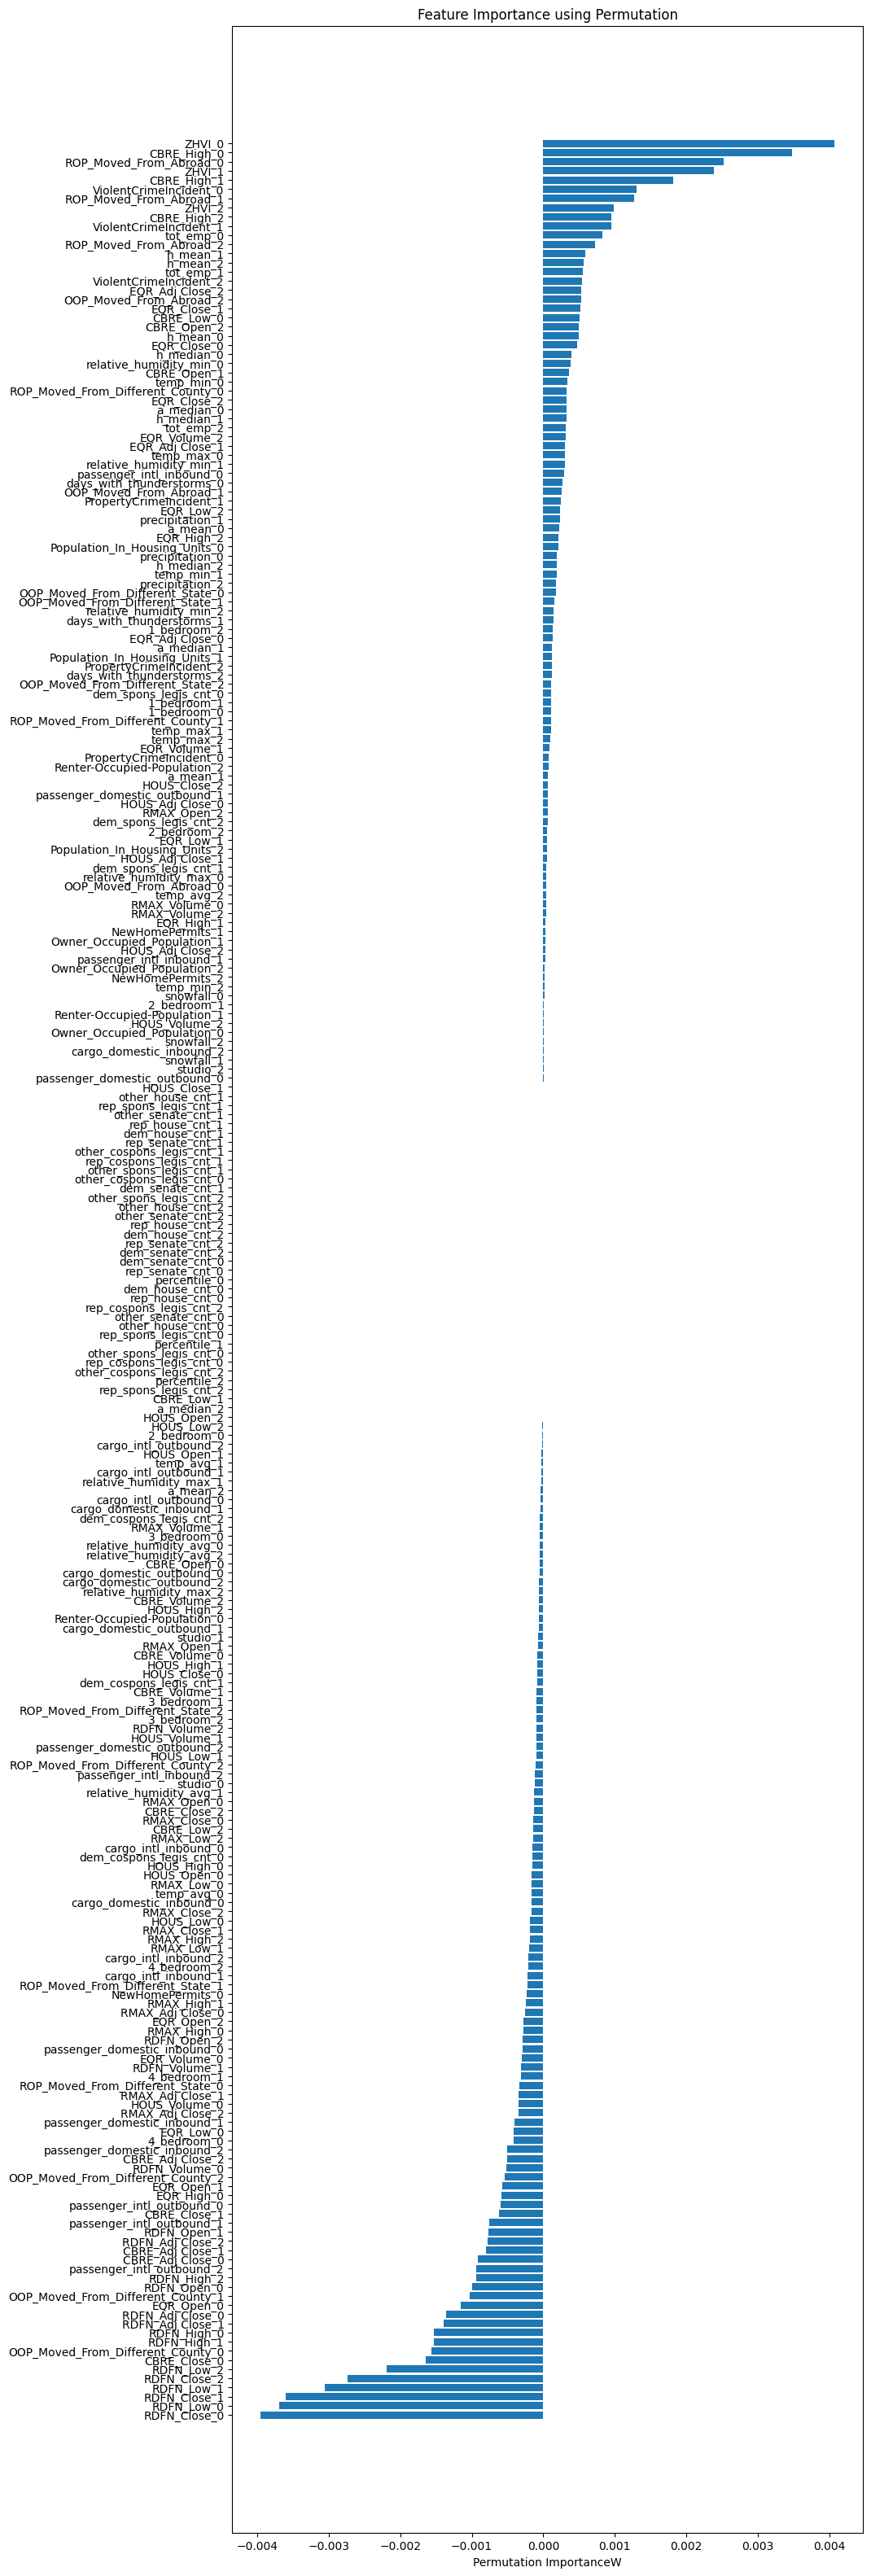

In [7]:
# Plot feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Generate feature names for the flattened input
original_feature_names = city_data.columns.drop(['Date', 'City']).tolist()
feature_names = [f"{feature}_{i}" for i in range(window_size) for feature in original_feature_names]

# Plot the feature importance results
plt.figure(figsize=(10, 40)) 
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation ImportanceW")
plt.title("Feature Importance using Permutation")
plt.show()

In [8]:
# Aggregate permutation importance scores for each feature across the three windows
aggregated_importance = {}
for feature in original_feature_names:
    aggregated_importance[feature] = sum(
        perm_importance.importances_mean[i] for i in range(len(feature_names)) if feature in feature_names[i]
    )

# Get the top 3 contributing features
sorted_features = sorted(aggregated_importance.items(), key=lambda x: x[1], reverse=True)
top_5_features = sorted_features[:5]

features_to_use = []
# Print the top 3 contributing features
print("Top 5 contributing features based on permutation importance:")
for feature, importance in top_5_features:
    print(f"{feature}: {importance}")
    if(feature != 'ZHVI'):
        features_to_use.append(feature)

Top 5 contributing features based on permutation importance:
ZHVI: 0.007433136733824533
CBRE_High: 0.006259289541651273
ROP_Moved_From_Abroad: 0.004518367561979997
ViolentCrimeIncident: 0.0028108441861644574
tot_emp: 0.0017001108789971159


In [13]:
### PLEASE RUN WITH CAUTION, RUNING THIS CELL WILL OVER WRITE THE RESULT SAVED IN THE FOLDER ###

# Save Feature Selection result
import json

# Only keep the important features for HyperParameterTunning
requried_columns = ['City', 'Date', 'ZHVI']
selected_features = requried_columns + features_to_use

with open('Results/Seattle/feature_selection.json', 'w') as file:
    json.dump(selected_features, file)

## 3. Model Training

In [63]:
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [64]:
import json
# Load the selected features
with open('Results/Seattle/feature_selection.json', 'r') as file:
    selected_features = json.load(file)

selected_features_city_df = city_data[selected_features]

# Reorganize to make sure ZHVI is the first column
columns = selected_features_city_df.columns.tolist()
columns.insert(0, columns.pop(columns.index('ZHVI')))
selected_features_city_df = selected_features_city_df[columns]

selected_features_city_df.columns

Index(['ZHVI', 'City', 'Date', 'CBRE_High', 'ROP_Moved_From_Abroad',
       'ViolentCrimeIncident', 'tot_emp'],
      dtype='object')

In [73]:
results = {}

# Use Window size 3 as we know it's the best
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Train the model
model, history = create_and_train_lstm(X_train, y_train, epochs=300, batch_size=32)

# Make predictions
lstm_preds = make_predictions(model, X_test, scaler)
actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = actual_vals[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
results = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
print(f'Seattle - MSE: {mse:.2f}')

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.1164 - val_loss: 0.6241
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0820 - val_loss: 0.4618
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0512 - val_loss: 0.3082
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0268 - val_loss: 0.1727
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0150 - val_loss: 0.0782
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0185 - val_loss: 0.0351
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0221 - val_loss: 0.0322
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0202 - val_loss: 0.0506
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0147 - val_loss: 0.0787
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0116 - val_loss: 0.1007
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0116 - val_loss: 0.1057
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0106 - val_l

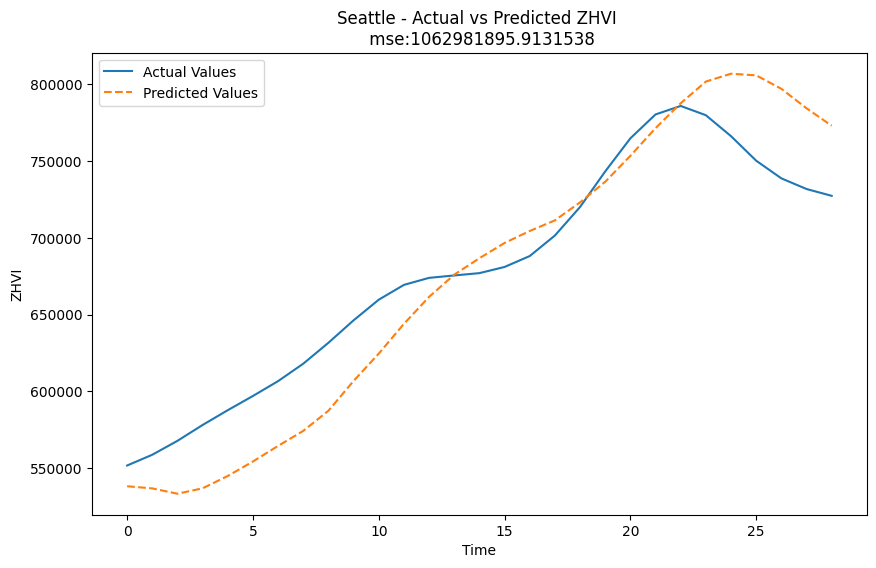

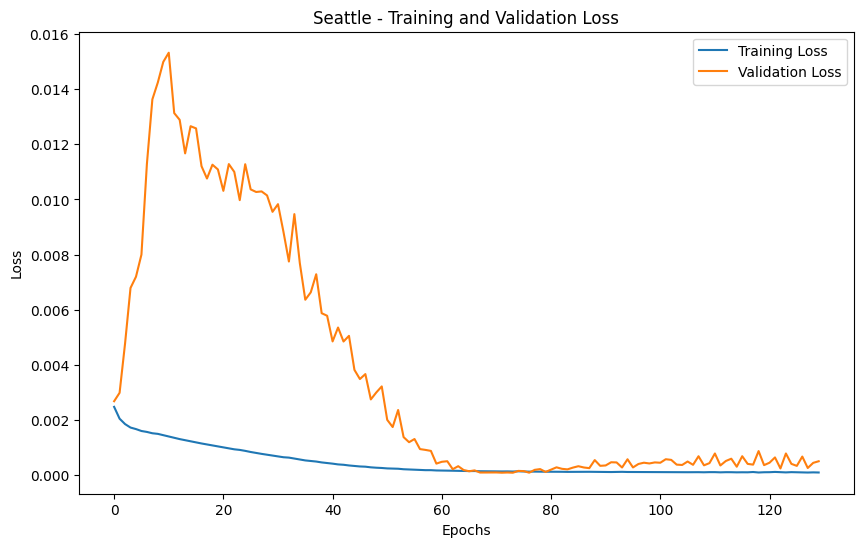

In [74]:

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results['actuals'], label='Actual Values')
plt.plot(results['predictions'], label='Predicted Values', linestyle='--')
plt.title(f"Seattle - Actual vs Predicted ZHVI \n mse:{results['mse']}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(results['history'].history['loss'][20:], label='Training Loss')
plt.plot(results['history'].history['val_loss'][20:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Seattle - Training and Validation Loss")
plt.show()

In [75]:
### PLEASE RUN WITH CAUTION, RUNING THIS CELL WILL OVER WRITE THE RESULT SAVED IN THE FOLDER ###

# Save the result
# Save the model results
import pickle
import numpy as np

# Define file paths
model_filepath = 'Results/Seattle/lstm_untuned/lstm_model.keras'
history_filepath = 'Results/Seattle/lstm_untuned/training_history.pkl'
actual_vals_filepath = 'Results/Seattle/lstm_untuned/actual_vals.npy'
predict_vals_filepath = 'Results/Seattle/lstm_untuned/lstm_predict_vals.npy'

# Save the model
model.save(model_filepath)

# Save the history
with open(history_filepath, 'wb') as f:
    pickle.dump(history.history, f)

# Save actual values and predicted values
np.save(actual_vals_filepath, actual_vals)
np.save(predict_vals_filepath, lstm_preds)

## 4. HyperParameters Tuning
Use Random Search to find out what are the best hyper parameters to use

In [25]:
# Import packages for Feature Importance Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers  import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from kerastuner.tuners import RandomSearch
import shutil


C:\Users\Steven\AppData\Local\Temp\ipykernel_13036\2951440225.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [38]:
shutil.rmtree('hyperparam_tuning/lstm_tuning_seattle', ignore_errors=True)

In [39]:
# Function to preprocess the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Preprocess data
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Build model function
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units_layer1', min_value=30, max_value=100, step=10),
                   return_sequences=True,
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=hp.Int('units_layer2', min_value=30, max_value=100, step=10),
                   kernel_regularizer=l2(0.001)))
    model.add(Dropout(rate=hp.Float('dropout_layer', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
   
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'])
    return model

# Create tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=40,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='lstm_tuning_seattle')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=20, restore_best_weights=True)

# Run the tuner search with early stopping
tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])

Trial 40 Complete [00h 00m 14s]
val_mean_squared_error: 0.0002503854047972709

Best val_mean_squared_error So Far: 0.00020155873789917678
Total elapsed time: 00h 07m 47s


In [40]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(f"Units Layer 1: {best_hyperparameters.get('units_layer1')}")
print(f"Units Layer 2: {best_hyperparameters.get('units_layer2')}")
print(f"Dropout Layer 1: {best_hyperparameters.get('dropout_layer')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Units Layer 1: 80
Units Layer 2: 60
Dropout Layer 1: 0.5
Learning Rate: 0.004427672340902837


In [41]:
trials = tuner.oracle.get_best_trials(num_trials=10)
trial_data = []

for trial in trials:
    trial_data.append({
        'units_layer1': trial.hyperparameters.values['units_layer1'],
        'units_layer2': trial.hyperparameters.values['units_layer2'],
        'dropout_layer2': trial.hyperparameters.values['dropout_layer'],
        'learning_rate': trial.hyperparameters.values['learning_rate'],
        'val_mean_squared_error': trial.metrics.get_best_value('val_mean_squared_error')
    })

trial_df = pd.DataFrame(trial_data)
print("\nTop 10 Hyperparameter Combinations:")
trial_df


Top 10 Hyperparameter Combinations:


,units_layer1,units_layer2,dropout_layer2,learning_rate,val_mean_squared_error
0,80,60,0.5,0.004428,0.000202
1,50,80,0.1,0.006405,0.000208
2,90,70,0.5,0.001955,0.000238
3,60,90,0.4,0.009460,0.000244
4,100,90,0.2,0.004585,0.000246
5,50,50,0.5,0.001074,0.000249
6,70,100,0.5,0.004224,0.000249
7,100,90,0.5,0.000836,0.000250
8,40,80,0.5,0.005580,0.000260
9,90,70,0.1,0.002198,0.000274


In [42]:
### PLEASE RUN WITH CAUTION, RUNING THIS CELL WILL OVER WRITE THE RESULT SAVED IN THE FOLDER ###
trial_df.to_csv('Results/Seattle/RandomSearchResult.csv', index=False)

## 4. Train a model with best HyperParameters

In [76]:
# Function to process the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=80, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=60, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [77]:
model_results = {}

# Use Window size 3 as we know it's the best
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Train the model
model, history = create_and_train_lstm(X_train, y_train, epochs=300, batch_size=32)

# Make predictions
lstm_preds = make_predictions(model, X_test, scaler)
actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = actual_vals[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
model_results = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
print(f'Seattle - MSE: {mse:.2f}')

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - loss: 0.2600 - val_loss: 0.8440 - learning_rate: 0.0010
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2132 - val_loss: 0.6546 - learning_rate: 0.0010
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1795 - val_loss: 0.4854 - learning_rate: 0.0010
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1518 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1278 - val_loss: 0.2157 - learning_rate: 0.0010
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1227 - val_loss: 0.1577 - learning_rate: 0.0010
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1237 - val_loss: 0.1464 - learning_rate: 0.0010
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1129 - val_loss: 0.1611 - learning_rate: 0.0010
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1072 - val_loss: 0.1867 - learning_rate: 0.0010
Epoch 10/300
3/3 ━━━━━━━━━━

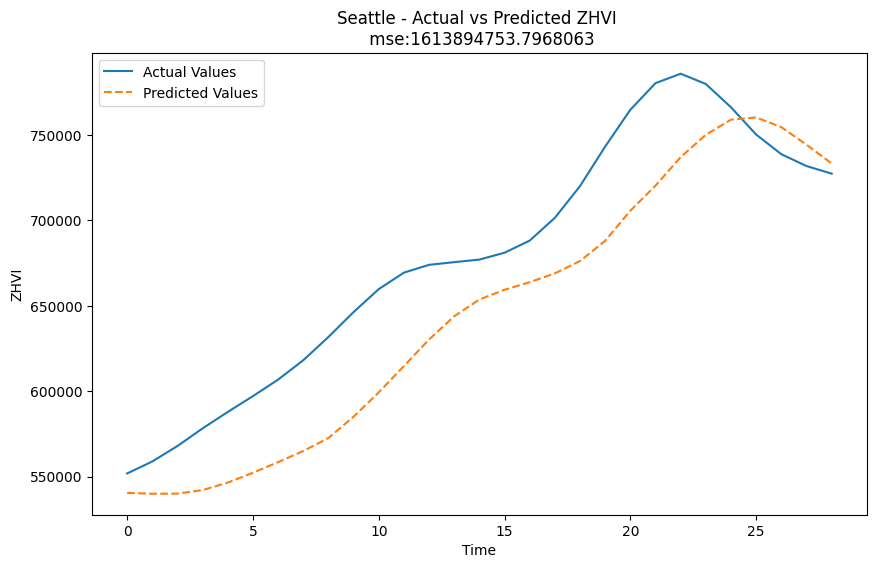

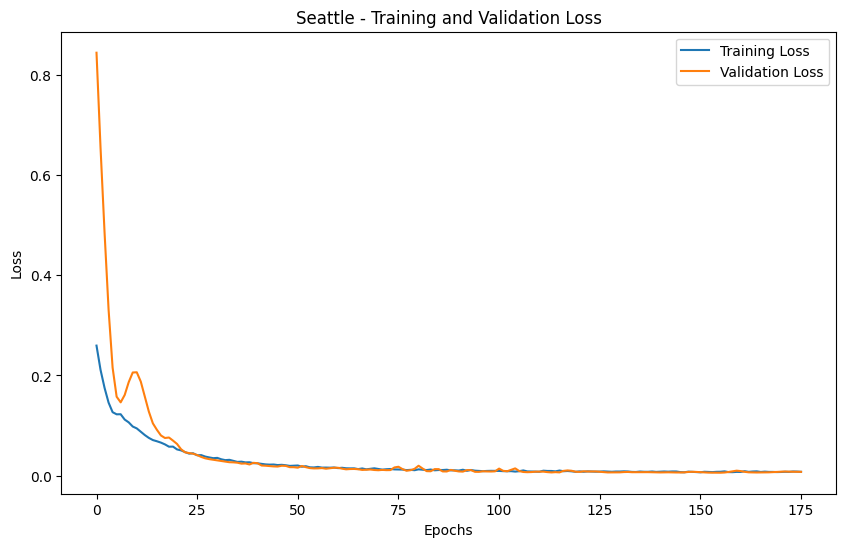

In [78]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(model_results['actuals'], label='Actual Values')
plt.plot(model_results['predictions'], label='Predicted Values', linestyle='--')
plt.title(f"Seattle - Actual vs Predicted ZHVI \n mse:{model_results['mse']}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(model_results['history'].history['loss'], label='Training Loss')
plt.plot(model_results['history'].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Seattle - Training and Validation Loss")
plt.show()

In [79]:
### PLEASE RUN WITH CAUTION, RUNING THIS CELL WILL OVER WRITE THE RESULT SAVED IN THE FOLDER ###

# Save the model results
import pickle
import numpy as np

# Define file paths
model_filepath = 'Results/Seattle/lstm_tuned/lstm_model.keras'
history_filepath = 'Results/Seattle/lstm_tuned/training_history.pkl'
actual_vals_filepath = 'Results/Seattle/lstm_tuned/actual_vals.npy'
predict_vals_filepath = 'Results/Seattle/lstm_tuned/lstm_predict_vals.npy'

# Save the model
model.save(model_filepath)

# Save the history
with open(history_filepath, 'wb') as f:
    pickle.dump(history.history, f)

# Save actual values and predicted values
np.save(actual_vals_filepath, actual_vals)
np.save(predict_vals_filepath, lstm_preds)

# 5. Performance Evaluation

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

with open('Results/lstm_baseline_mse.json', 'r') as json_file:
    lstm_baseline_mse = json.load(json_file)

with open('Results/lstm_baseline_prediction.json', 'r') as json_file:
    lstm_baseline_prediction = json.load(json_file)

with open('Results/mean_baseline_mse.json', 'r') as json_file:
    mean_baseline_mse = json.load(json_file)

with open('Results/mean_baseline_prediction.json', 'r') as json_file:
    mean_baseline_prediction = json.load(json_file)

# use untuned model here as it performs better 
actual_zhvi = np.load('Results/Seattle/lstm_untuned/actual_vals.npy')
lstm_prediction =  np.load('Results/Seattle/lstm_untuned/lstm_predict_vals.npy')

In [2]:
lstm_baseline_mse = lstm_baseline_mse['Seattle']
lstm_baseline_prediction = lstm_baseline_prediction['Seattle']
mean_baseline_mse = mean_baseline_mse['Seattle']
mean_baseline_prediction = mean_baseline_prediction['Seattle']


Final LSTM MSE: 521826814.17
Improvement over LSTM baseline MSE: 33059192099.65 (98.45%)
Improvement over mean baseline MSE: 817454723.36 (61.04%)


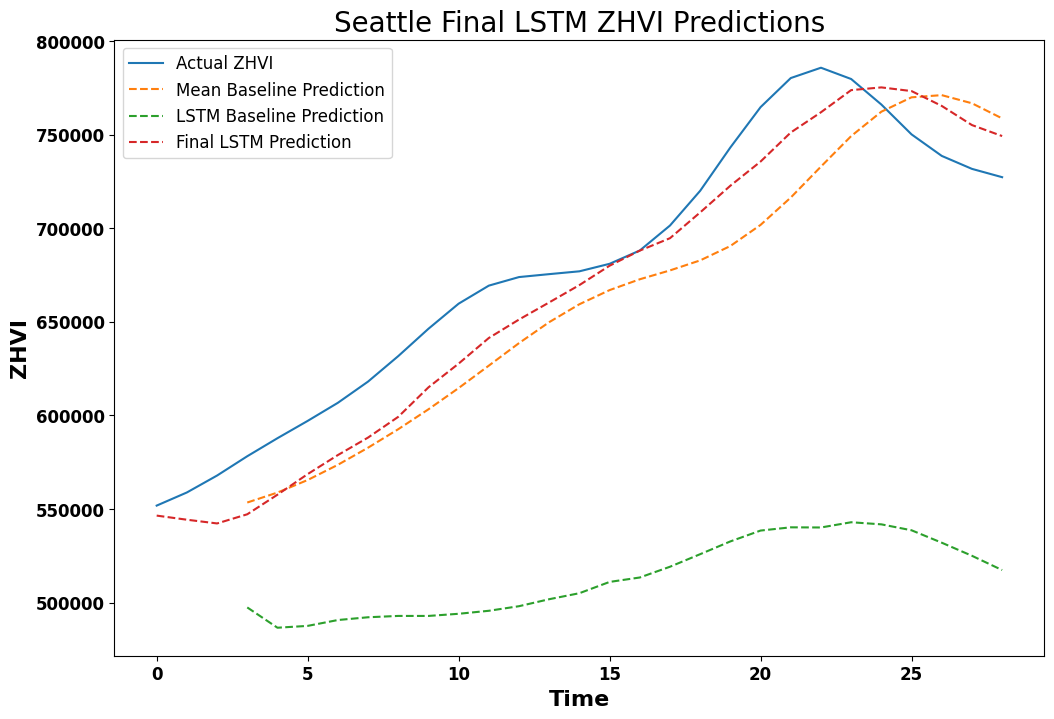

In [3]:
# Calculate the MSE for the final LSTM prediction
final_lstm_mse = mean_squared_error(actual_zhvi, lstm_prediction)

# Calculate the improvement in MSE
improvement_lstm_baseline = lstm_baseline_mse - final_lstm_mse
improvement_mean_baseline = mean_baseline_mse - final_lstm_mse

# Calculate the percentage improvement
improvement_lstm_baseline_percent = (improvement_lstm_baseline / lstm_baseline_mse) * 100
improvement_mean_baseline_percent = (improvement_mean_baseline / mean_baseline_mse) * 100

print(f'Final LSTM MSE: {final_lstm_mse:.2f}')
print(f'Improvement over LSTM baseline MSE: {improvement_lstm_baseline:.2f} ({improvement_lstm_baseline_percent:.2f}%)')
print(f'Improvement over mean baseline MSE: {improvement_mean_baseline:.2f} ({improvement_mean_baseline_percent:.2f}%)')

# Calculate the padding
mean_padding = 6 - 3 # Mean Baseline window size - LSTM model window size
lstm_baseline_padding = 6 - 3 # LSTM Baseline window size - LSTM model window size

# Pad the arrays with zeros (or another value, such as NaN if you want to hide the padded values)
mean_baseline_padded = np.pad(mean_baseline_prediction, (mean_padding, 0), 'constant', constant_values=(np.nan,))
lstm_baseline_padded = np.pad(lstm_baseline_prediction, (lstm_baseline_padding, 0), 'constant', constant_values=(np.nan,))

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(actual_zhvi, label='Actual ZHVI')
plt.plot(mean_baseline_padded, label='Mean Baseline Prediction', linestyle='--')
plt.plot(lstm_baseline_padded, label='LSTM Baseline Prediction', linestyle='--')
plt.plot(lstm_prediction, label='Final LSTM Prediction', linestyle='--')
plt.title('Seattle Final LSTM ZHVI Predictions', fontsize=20)
plt.xlabel('Time', fontsize=16, fontweight='bold')
plt.ylabel('ZHVI', fontsize=16, fontweight='bold')

# Bold the axis ticks
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')

plt.legend(fontsize=12)
plt.show()